In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

## Ridge, Lasso

Implement ridge and lasso regression. Both model should fit the intercept without penalization. Use a closed-form solution for ridge regression and any optimization method for lasso (for example, the Powell method from scipy).

Implement models as classes (RidgeReg, LassoReg) which take a regularization weight as their constructor parameter and provide methods fit(X, y) and predict(X). Objects X and y are numpy arrays, fit fits the model and doesn't return anything, while predict returns predicted values. Add your own tests for testing the correctness and expected behavior of your solution.

Application

Apply your Ridge regression model to the provided superconductivity data set (superconductor.csv). It contains data about different superconducting materials with the goal of modeling their critical temperatures. The data set was somewhat adapted for the the purposes of this homework. Your goal is to minimize the model's root mean square error (RMSE). Use the first 200 examples as your training data for building the model and selecting an appropriate regularization weight. Note that you have relatively few data samples. Finally, estimate the model's RMSE on the other 100 examples.

Submit two files: a short (max 2 pages) report (.pdf) and your code (a single Python 3.8-compatible file; your code should only run things under if __name__ == "__main__").


In [2]:
def normalize(x):
    def nf(f):
        temp = np.max(f) - np.min(f)
        nf = (f - np.min(f)) / (temp)
        return nf

    return np.apply_along_axis(func1d=nf, axis=0, arr=x)


In [3]:
def rmse(yp, yt):
    return np.sqrt(((yp - yt)**2).mean())

In [7]:
class Regression:
    def __init__(self, fit_intercept):
        self.fit_intercept = fit_intercept

    def predict(self, xp):
        def fun(x):
            res = 0
            if (self.fit_intercept):
                res = self.beta[0] + self.beta[1:].T.dot(x)
            else:
                res = self.beta.T.dot(x)
            return res

        return np.ravel(np.apply_along_axis(func1d=fun, axis=1, arr=xp))

In [8]:
class LinReg(Regression):
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def cost_f(self, beta0):
        self.beta = beta0
        res = np.sum((self.predict(self.x) - self.y)**2) / (2 * len(self.y))
        return res

    def fit(self, X, y):
        self.y = y
        if (self.fit_intercept):
            self.x = np.append(np.ones((X.shape[0], 1)), X, axis=1)
            self.p = X.shape[1] + 1
        else:
            self.x = X
            self.p = X.shape[1]
        res = np.linalg.inv(self.x.T.dot(self.x))
        self.beta_th = res.dot(self.x.T.dot(self.y))
        self.x = X
        # self.beta = self.beta_th
        self.beta = np.zeros(self.p)
        self.weights = minimize(self.cost_f, self.beta, method='Powell')
        self.beta = self.weights['x']

        return self

In [9]:
class RidgeReg(Regression):
    def __init__(self, lambda_, fit_intercept=True):
        self.l = lambda_
        self.fit_intercept = fit_intercept

    def loss_f(self, beta0):
        self.beta = beta0
        pred = self.predict(self.x)
        res = np.sum((pred - self.y)**2) / (2 * len(self.y)) + self.l * np.sum(
            self.beta**2)
        return res

    def fit(self, X, y):
        self.y = y

        if (self.fit_intercept):
            self.x = np.append(np.ones((X.shape[0], 1)), X, axis=1)
            self.p = X.shape[1] + 1
        else:
            self.x = X
            self.p = X.shape[1]

        self.alpha = np.linalg.inv(
            (self.x.T.dot(self.x) + self.l * np.eye(self.p)))
        temp = self.alpha.dot(self.x.T)
        self.beta_th = temp.dot(self.y)
        self.beta_th = self.beta_th.reshape((len(self.beta_th), 1))
        self.x = X
        self.beta = np.zeros(self.p)
        self.weights = minimize(self.loss_f, self.beta, method='Powell')
        self.beta = self.weights['x']
        self.beta = self.beta_th
        return self

In [10]:
class LassoReg(Regression):
    def __init__(self, lambda_, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.l = lambda_

    def loss_f(self, beta0):
        self.beta = beta0
        pred = self.predict(self.x)
        res = np.sum((pred - self.y)**2) / (2 * len(self.y)) + self.l * np.sum(
            np.abs(self.beta))
        return res

    def fit(self, X, y):
        # scaler = StandardScaler().fit(X)
        # X = scaler.transform(X)
        self.y = y
        if (self.fit_intercept):
            self.x = np.append(np.ones((X.shape[0], 1)), X, axis=1)

            self.p = X.shape[1] + 1
        else:
            self.x = X
            self.p = X.shape[1]
        res = np.linalg.inv(self.x.T.dot(self.x))
        self.beta_th = res.dot(self.x.T.dot(self.y))
        self.x = X
        self.beta = np.zeros(self.p)
        # self.beta = self.beta_th
        self.weights = minimize(self.loss_f, self.beta, method='Powell')
        self.beta = self.weights['x']
        return self

###  Data Import and preparation

In [11]:
df = pd.read_csv('superconductor.csv')
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()
X = normalize(X)
X_train, X_test = X[:200, :], X[200:, :]
y_train, y_test = y[:200], y[200:]

### Testing model on introduced data:

In [12]:
lin_reg_org = LinReg().fit(X_train, y_train)

In [13]:
print('RMSE (LINREG):',rmse(lin_reg_org.predict(X_test),y_test))

RMSE (LINREG): 23.638960458936552


In [14]:
lasso_reg_org = LassoReg( lambda_ = 1).fit(X_train,y_train)

In [15]:
print('RMSE (LASSOREG):',rmse(lasso_reg_org.predict(X_test),y_test))

RMSE (LASSOREG): 18.257374603193878


In [16]:
ridge_reg_org = RidgeReg( lambda_ = 1).fit(X_train,y_train)

In [17]:
print('RMSE (RIDGEREG):',rmse(ridge_reg_org.predict(X_test),y_test))

RMSE (RIDGEREG): 13.588195643187555


In [18]:
def get_cv(train_i,test_i,model):
    X_train, X_test = X[train_i], X[test_i]
    y_train, y_test = y[train_i], y[test_i]
    model = model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    return dict(rmse_train = rmse(y_train_pred,y_train),rmse_test = rmse(y_test_pred,y_test))

### Checking data for overfit:

If we check the Linear reg. model for overfit via CV through train and test set, 
we can introduce Lasso Regression to check feature importance which will reduce model complexity and introduce positive bias for better model performance.

In [19]:

n_split = 10

In [20]:

kf = KFold(n_splits=n_split)
out_lin = Parallel(n_jobs=-1, verbose=100, pre_dispatch='1.5*n_jobs')(delayed(get_cv)
                                                                 (train_i, test_i, LinReg()) for train_i, test_i in kf.split(X))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:   44.8s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   54.9s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:   55.7s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   58.5s remaining:   58.5s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   58.6s remaining:   39.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   59.7s remaining:   25.6s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  1.0min remaining:   15.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


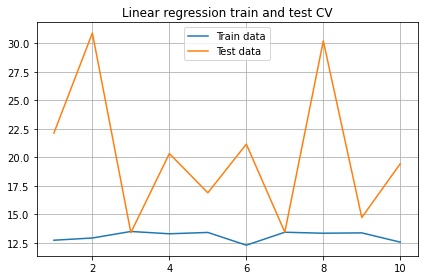

In [21]:
plt.plot(1 + np.arange(n_split),[x['rmse_train'] for x in out_lin],label= 'Train data')
plt.plot(1 + np.arange(n_split),[x['rmse_test'] for x in out_lin],label = 'Test data')
plt.legend()
plt.title('Linear regression train and test CV')
plt.grid()
plt.tight_layout()
plt.show()

We can see that train performance baseline result is substantially less then test set.

In [22]:
kf = KFold(n_splits=n_split)
out_lasso = Parallel(n_jobs=-1, verbose=100, pre_dispatch='1.5*n_jobs')(delayed(get_cv)
                                                                 (train_i, test_i, LassoReg(lambda_=1)) for train_i, test_i in kf.split(X))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  1.1min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.1min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.3min remaining:   51.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.3min remaining:   33.2s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  1.3min remaining:   20.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.4min finished


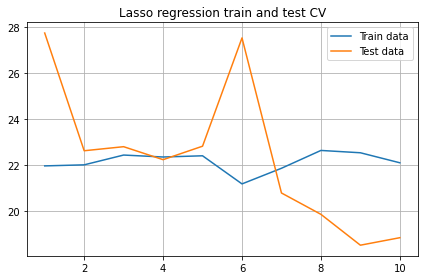

In [23]:
plt.plot(1 + np.arange(n_split),[x['rmse_train'] for x in out_lasso],label= 'Train data')
plt.plot(1 + np.arange(n_split),[x['rmse_test'] for x in out_lasso],label = 'Test data')
plt.legend()
plt.title('Lasso regression train and test CV')
plt.grid()
plt.tight_layout()
plt.show()

Lasso regression reduced overfit via regularization, by reducing coefficient (leading them to 0), for features which are responsible for induced overfit.

In [24]:
kf = KFold(n_splits=n_split)
out_ridge = Parallel(n_jobs=-1, verbose=100, pre_dispatch='1.5*n_jobs')(delayed(get_cv)
                                                                 (train_i, test_i, RidgeReg(lambda_=1, fit_intercept=True)) for train_i, test_i in kf.split(X))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:   15.7s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   16.0s remaining:   37.4s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:   18.0s remaining:   27.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   18.6s remaining:   18.6s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   18.7s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   18.8s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:   19.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.8s finished


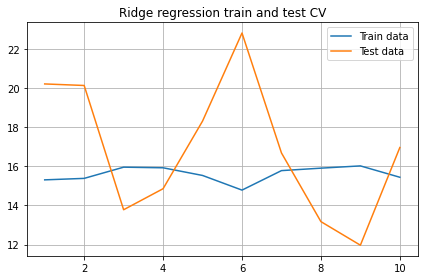

In [25]:
plt.plot(1 + np.arange(n_split),[x['rmse_train'] for x in out_ridge],label= 'Train data')
plt.plot(1 + np.arange(n_split),[x['rmse_test'] for x in out_ridge],label = 'Test data')
plt.legend()
plt.title('Ridge regression train and test CV')
plt.grid()
plt.tight_layout()
plt.show()

In [26]:
lasso_ind = np.where( ( lasso_reg_org.weights['x']!=0) )[0]
ridge_ind = np.where(ridge_reg_org.weights['x']!=0)[0]
print(len(lasso_ind),len(ridge_ind))

32 82


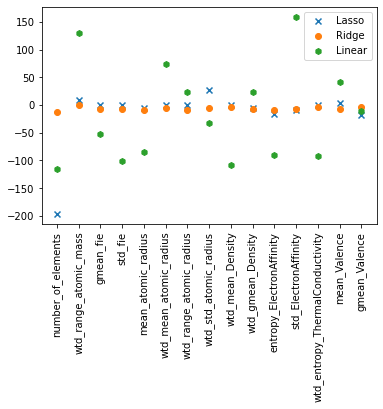

In [156]:

plt.scatter(df.columns[:-1][lasso_ind],(lasso_reg_org.weights['x'])[lasso_ind],label='Lasso',marker='x')
plt.scatter(df.columns[:-1][lasso_ind],(ridge_reg_org.weights['x'])[lasso_ind],label='Ridge')
plt.scatter(df.columns[:-1][lasso_ind],(lin_reg_org.weights['x'])[lasso_ind],label='Linear',marker='h')

plt.legend()
plt.xticks(rotation=90)
plt.show()

We can see that remaining non-null coefficients in Lasso Regression regularization are substantially reduced when compared with Linear regression. Approach of Ridge regression is to shrink coeff. thus improving the overall performance, visible on the plot.

In [69]:
lasso_ind = np.where((lasso_reg_org.weights['x']>1e-11) | (lasso_reg_org.weights['x']<-1e-11))[0]
lin_reg_red = LinReg().fit(X_train[:,lasso_ind],y_train)
print('RMSE (LIN_REG_REDUCED): ', rmse(lin_reg_red.predict(X_test[:,lasso_ind]),y_test))

RMSE (LIN_REG_REDUCED):  19.154562626447465


Using selected non-null (or substaintally reduced) coefficient to select reduced features for linear regression, thus improving RMSE.

In [70]:
from sklearn.model_selection import GridSearchCV

In [84]:
l =  [1,2,0.1, 0.01,0.001,5,10]

for ll in l:
    clf = RidgeReg(lambda_=ll).fit(X_train,y_train)
    print(ll,' : ',rmse(clf.predict(X_test),y_test))


1  :  13.588195643187555
2  :  13.559050740566924
0.1  :  17.148832040134035
0.01  :  21.8925508579812
0.001  :  32.51046720644312
5  :  14.816585418964964
10  :  16.967075467244122


### Kernelized Ridge Regression

In [4]:
class Linear:
    """An example of a kernel."""

    def __init__(self):
        # here a kernel could set its parameters
        pass

    # a-xprim b-x

    def __call__(self, A, B):
        """Can be called with vectors or matrices, see the
        comment for test_kernel"""
        return A.dot(B.T)

In [5]:
class Polynomial:
    def __init__(self, M=1):
        self.M = M

    def __call__(self, xprim, x, c=1):
        res = (np.dot(xprim, x.T) + c)
        return (res**self.M)

In [6]:
class RBF:
    def __init__(self, sigma=1):
        self.sigma = sigma

    def __call__(self, xprim, x):
        # dis = x.T.dot(x)+xprim.T.dot(xprim) - 2*(np.dot(x.T, xprim))
        # return np.exp((-dis/(2*self.sigma**2)))
        def dmatrix(xprim, x):
            x_ax = None
            xp_ax = None
            if (xprim.ndim == 2):
                xp_ax = 1
            if (x.ndim == 2):
                x_ax = 1
            nxp = (xprim**2).sum(axis=xp_ax)
            nx = (x**2).sum(axis=x_ax)
            return (nxp.reshape(-1, 1) + nx - 2 * np.dot(xprim, x.T))

        def rbf(xp, x):
            _gamma = 1. / (2 * self.sigma**2)
            dists_sq = dmatrix(xp, x)
            return np.exp(-_gamma * dists_sq)

        return np.squeeze(rbf(xprim, x))

In [85]:
class KernelizedRidgeRegression:
    def __init__(self, lambda_, kernel=Linear):
        self.k = kernel
        self.l = lambda_

    def gramm(self):
        # Kernelizing Gram Matrix
        def f2(xprim, x2):
            return self.k(xprim, x2)

        def f1(x1):
            return np.apply_along_axis(func1d=f2, arr=self.x, axis=1, x2=x1)

        return np.apply_along_axis(func1d=f1, arr=self.x, axis=1)

    def fit(self, x, y):

        self.x = x
        self.y = y
        f_size = self.x.shape[0]
        gr = self.gramm()
        # print(gr[0][:10])
        self.alpha = np.linalg.inv((gr + self.l * np.eye(f_size)))
        self.alpha = self.alpha.dot(self.y)
        self.beta = self.x.T.dot(self.alpha)

        return self

    def predict(self, xp):
        def kernel_res(xprim):
            return np.apply_along_axis(func1d=ker,
                                       axis=1,
                                       arr=self.x,
                                       xprim=xprim)

        def ker(x_i, xprim):
            return self.k(xprim, x_i)

        res = np.apply_along_axis(func1d=kernel_res, axis=1, arr=xp)
        yhat = res.dot(self.alpha)
        return yhat

In [157]:
ridge_reg_org = RidgeReg( lambda_ = 2).fit(X_train,y_train)

In [158]:
print('RMSE (RIDGEREG):',rmse(ridge_reg_org.predict(X_test),y_test))

RMSE (RIDGEREG): 13.559050740566924


In [159]:
ker_ridge_reg = KernelizedRidgeRegression(lambda_=1,kernel=Linear()).fit(X_train,y_train)

In [160]:
print('RMSE (Ker Ridge Reg):', rmse(ker_ridge_reg.predict(X_test),y_test))

RMSE (Ker Ridge Reg): 13.498212831736286


We can use Kernelized Ridge Regression with different kernels to improve train performance calculations of base Ridge regression due to lower cost of computation and optimization, thus elapsed time is smaller, by omitting need for optimization method in Kernelized ridge implementation.

* Ridge regression: `6.3s` 
* Kernelized ridge regression: `0.1s`